In [24]:
!pip install tqdm

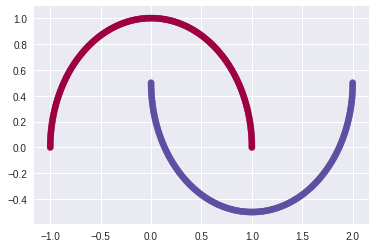

In [25]:
%matplotlib inline
import math
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from sklearn.datasets.samples_generator import make_moons
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from tqdm import tqdm


# DATA FOR CLASSIFICATION
np.random.seed(0)
# X, y = make_blobs(n_samples=400, centers=2, n_features=2, cluster_std=0.1,random_state=0)
X, y = make_moons(n_samples=400, shuffle=True, noise=None,random_state=0)
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)

reshaped_y = np.array(y).reshape(len(y),1)

enc = OneHotEncoder()
enc.fit(reshaped_y)
encoded_y = enc.transform(reshaped_y).toarray()

X_train, X_test, y_train, y_test = train_test_split(X, encoded_y, test_size=0.33, random_state=42)
# --------------------------

In [0]:
import numpy as np


# FUNCTIONS FOR FORWARD PASS
def ReLU(x):
    y = []
    for scalar in x:
        y.append(scalar * (scalar > 0))
    return np.array(y)


def softmax(x):
    e_x = np.exp(x - np.max(x))
    out = e_x / e_x.sum()
    return out


def differentiate_ReLU(a_2):
        if (a_2 >= 0):
            return 1
        else:
            return 0

def differentiate_tanh(a_1):
    return 1 - np.tanh(a_1)**2

In [0]:
class NeuralNetwork:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
        np.random.seed(4)
        self.W_1 = np.random.rand(2,2)
        self.W_2 = np.random.rand(2,2)
        self.W_out = np.random.rand(2,2)
        self.W_ResNet = np.random.rand(2,2)
        
        self.b_1 = np.random.rand(2)
        self.b_2 = np.random.rand(2)
        self.b_out = np.random.rand(2)

def feedforward(network, x, y):
        forward_path = dict()
        
        forward_path['x'] = x
        forward_path['y'] = y
        
        forward_path['a_1'] = np.add(network.W_1.dot(x), network.b_1)
        forward_path['z_1'] = np.tanh(forward_path['a_1'])
        forward_path['a_2'] = np.add(network.W_2.dot(forward_path['z_1']), network.b_2)
        forward_path['z_2'] = ReLU(forward_path['a_2'])
        forward_path['a_out_1'] = network.W_out.dot(forward_path['z_2'])
        forward_path['a_out_2'] = network.W_ResNet.dot(x)
        forward_path['a_out'] = np.add(np.add(forward_path['a_out_1'], forward_path['a_out_2']), network.b_out)
        forward_path['z_out'] = softmax(forward_path['a_out'])
        
        return forward_path
        
        
def get_gradient(network, hidden_state):
        gradient = dict()
        
        derivative_of_tanh = np.vectorize(differentiate_tanh)(hidden_state['a_1'])
        derivative_of_ReLU = np.vectorize(differentiate_ReLU)(hidden_state['a_2'])
 
        # application of the chain rule to find derivative of the loss function with respect to weights2 and weights1
        delta_out = hidden_state['y'] - hidden_state['z_out'] 
        
        delta_2 = np.multiply(derivative_of_ReLU, network.W_out.T.dot(delta_out))
        delta_1 = np.multiply(derivative_of_tanh, network.W_2.T.dot(delta_2))
            
        dW_ResNet = np.matrix(delta_out).T.dot(np.matrix(hidden_state['x']))
        dW_out = np.matrix(delta_out).T.dot(np.matrix(hidden_state['z_2']))
        dW_2 = np.matrix(delta_2).T.dot(np.matrix(hidden_state['z_1']))
        dW_1 = np.matrix(delta_1).T.dot(np.matrix(hidden_state['x']))
        
        gradient['W_1'] = np.array(dW_1)
        gradient['W_2'] = np.array(dW_2)
        gradient['W_out'] = np.array(dW_out)
        gradient['W_ResNet'] = np.array(dW_ResNet)
        
        gradient['b_1'] = delta_1
        gradient['b_2'] = delta_2
        gradient['b_out'] = delta_out
        
        return gradient
    
def update_neural_network(network, gradient, learning_rate = 0.02):
    network.W_1 += learning_rate * gradient['W_1']
    network.W_2 += learning_rate * gradient['W_2']
    network.W_out += learning_rate * gradient['W_out']
    network.W_ResNet += learning_rate * gradient['W_ResNet']
        
    network.b_1 += learning_rate * gradient['b_1']
    network.b_2 += learning_rate * gradient['b_2']
    network.b_out += learning_rate * gradient['b_out']
    

In [33]:
nn = NeuralNetwork(X_train, y_train)
for iteration in range(1200):
    for x, y in zip(X_train, y_train):
        hs = feedforward(nn, x, y)
        gradient = get_gradient(nn, hs)
        update_neural_network(nn, gradient)
        
    if(iteration % 120 == 0):
        hs = feedforward(nn, X_test[0], y_test[0])
        print(log_loss(hs['y'], hs['z_out']))

0.23217194647701223
0.015957242671828638


KeyboardInterrupt: ignored

In [29]:
def gradient_check(epsilon = 1e-4):
    nn = NeuralNetwork(X_train, y_train)
    hs = feedforward(nn, nn.x[0], nn.y[0])
    gradient = get_gradient(nn, hs)
    
    nn_dumm = NeuralNetwork(X_train, y_train)
    nn_dumm.W_out[0][0] += epsilon
    hs_dumm = feedforward(nn_dumm, nn.x[0], nn.y[0])
    
    dE = (log_loss(hs_dumm['y'], hs_dumm['z_out']) - log_loss(hs['y'], hs['z_out']))
    db_out_0 = epsilon
    
    gradient_dumm = dE/db_out_0

    return gradient_dumm - gradient['W_out'][0][0]

gradient_check()

7.27662299526699e-07

In [30]:
def gradient_chec(epsilon = 1e-4):
    nn = NeuralNetwork(X_train, y_train)
    hs = feedforward(nn, nn.x[0], nn.y[0])
    gradient = get_gradient(nn, hs)
    
    
    diff = calc_df_da_1(hs['a_1'])[0]
    

    dE = (np.tanh(hs['a_1'][0]+epsilon) - np.tanh(hs['a_1'][0]))
    diff_dumm = dE/epsilon
    

    return diff_dumm - diff

gradient_chec()

-1.3750111711674506e-05